# Analysis of the RailSem19 dataset


The RailSem19 dataset can be obtained via [WildDash](https://wilddash.cc/railsem19).

> O. Zendel, M. Murschitz, M. Zeilinger, D. Steininger, S. Abbasi and C. Beleznai, RailSem19: A Dataset for Semantic Rail Scene Understanding, 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 2019, pp. 1221-1229, doi: 10.1109/CVPRW.2019.00161.

In [2]:
import json
import os

import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style="whitegrid", font="serif")
%matplotlib inline


In [3]:
def read_json(fp):
    with open(fp) as f:
        f_data = json.load(f)
    return f_data


data = read_json("./rs19_val/rs19-config.json")
type(data)


dict

Available classes in the semantic segmentation dataset:

In [4]:
classes = {idx: entry["name"] for idx, entry in enumerate(data["labels"])}
classes


{0: 'road',
 1: 'sidewalk',
 2: 'construction',
 3: 'tram-track',
 4: 'fence',
 5: 'pole',
 6: 'traffic-light',
 7: 'traffic-sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'human',
 12: 'rail-track',
 13: 'car',
 14: 'truck',
 15: 'trackbed',
 16: 'on-rails',
 17: 'rail-raised',
 18: 'rail-embedded'}

Load all JSON annotations of the object detection dataset:

In [5]:
fp_jsons = "./rs19_val/jsons/rs19_val"

labels = list(map(read_json, [os.path.join(fp_jsons, file) for file in os.listdir(fp_jsons)]))
print(f"{len(labels)} labels in total")

8500 labels


Classnames for the object detection dataset:

In [6]:
unique_classes = set().union(*((obj["label"] for obj in label["objects"]) for label in labels))

print(f"{len(unique_classes)} unique classes:")
unique_classes


21 unique classes:


{'buffer-stop',
 'car',
 'crossing',
 'fence',
 'guard-rail',
 'person',
 'person-group',
 'platform',
 'pole',
 'rail',
 'rail-occluder',
 'switch-indicator',
 'switch-left',
 'switch-right',
 'switch-static',
 'switch-unknown',
 'track-sign-front',
 'track-signal-back',
 'track-signal-front',
 'train-car',
 'truck'}

The number of images with at least one instance of the classes we're interested in:

In [7]:
n_person = sum(("person" in (obj["label"] for obj in label["objects"]) for label in labels))
n_person_group = sum(("person-group" in (obj["label"] for obj in label["objects"]) for label in labels))

f"{n_person=}, {n_person_group=}"


'n_person=167, n_person_group=48'

The total number of instances of the classes we're interested in:

In [8]:
total_person = sum(sum(obj["label"] == "person" for obj in label["objects"]) for label in labels)
total_person_group = sum(sum(obj["label"] == "person-group" for obj in label["objects"]) for label in labels)

f"{total_person=}, {total_person_group=}"


'total_person=234, total_person_group=62'

Total number of unique images where at least one instance of one relevant class is present:

In [9]:
unique_img_person = {label["frame"] for label in labels if "person" in (l["label"] for l in label["objects"])}
unique_img_person_group = {label["frame"] for label in labels if "person-group" in (l["label"] for l in label["objects"])}

len(unique_img_person | unique_img_person_group)


191

Total number of unique images with at least one instance of the label `person` but without any instance of the label `person-group`:

In [10]:
len(set(unique_img_person) - set(unique_img_person_group))


143

Total number of unique images with at least one instance of the label `person-group` but without any instance of the label `person`:

In [11]:
len(set(unique_img_person_group) - set(unique_img_person))


24

## Semantic Segmentation

Analysis of Semantic Segmentation labels. The labels are stored as uInt8 .png images in the folder `./rs19_val/uint8/rs19_val/`.

Example:

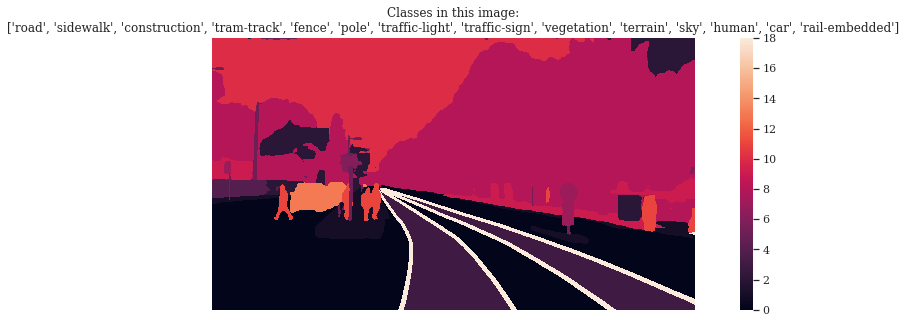

In [12]:
demo_image = cv2.imread("./rs19_val/uint8/rs19_val/rs00106.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(16, 5))
plt.title(f"Classes in this image:\n{[classes[k] for k in np.unique(demo_image) if k != 255]}")
sns.heatmap(demo_image, vmax=max(classes.keys()), xticklabels=False, yticklabels=False, square=True)
plt.show()


Number of images containing the relevant class:

In [13]:
fp_uint8 = "./rs19_val/uint8/rs19_val/"
class_human = 11

labels_uint8 = [file for file in os.listdir(fp_uint8) if class_human in cv2.imread(os.path.join(fp_uint8, file), cv2.IMREAD_GRAYSCALE)]
print(f"{len(labels_uint8)} labels containing class {class_human}: {classes[class_human]}")


2403 labels containing class 11: human


Example of a label and corresponding scene:

((1080, 1920), dtype('uint8'))

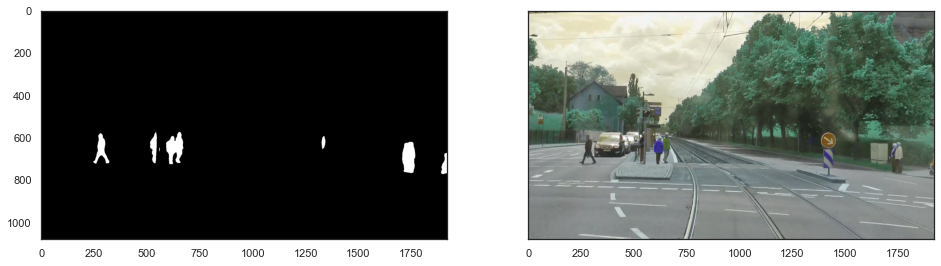

In [112]:
binary_image = (demo_image == class_human).astype(np.uint8)
demo_image_original = cv2.imread("./rs19_val/jpgs/rs19_val/rs00106.jpg")

fig, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
plt.grid(False)
ax[0].imshow(binary_image, cmap="gray")
ax[1].imshow(demo_image_original)

binary_image.shape, binary_image.dtype


Extracting the instances out of the binary image:

In [113]:
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
f"{len(contours)} contours found"

'7 contours found'

Image containing the found contours and corresponding bounding boxes:

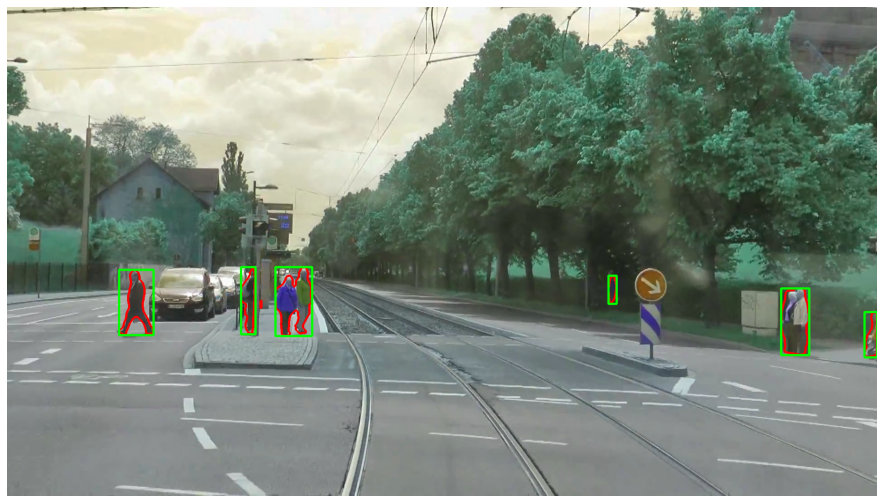

In [110]:
cv2.drawContours(demo_image_original, contours, -1, (255, 0, 0), 3)  # Instance segmentation

for c in contours:
    if cv2.contourArea(c) > 400:  # Filter too small bboxes
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(demo_image_original, (x, y), (x+w, y+h), (0, 255, 0), 3)  # Bounding Boxes

plt.figure(figsize=(16, 9))
plt.axis("off")
plt.imshow(demo_image_original)
plt.show()